In [1]:
# This notebook is used for testing plant models in the draculab module. Mostly, connections from plants to units.

# By Sergio Verduzco Flores        July 2017

# This file is supposed to be in .../draculab/tests/ , so cd before importing:
%cd ..
from draculab import *
from matplotlib import pyplot as plt
import time
import re

/home/z/projects/draculab


In [2]:
def loadData(filename):
    # Receives the name of a datafile saved in XPP's .dat format, 
    # and returns numpy arrays with the data from the columns
    # The format is simply putting in each line the values of time and state variables
    # separated by spaces. Time is the first column.
    
    # Counting the lines and columns in order to allocate the numpy arrays
    nlines = sum(1 for line in open(filename,'r'))
    n_columns = len(re.split(' .', open(filename,'r').readline()))
    # XPP puts an extra space at the end of the line, so I used ' .' instead of ' '
    
    # We'll store everything in one tuple of numpy arrays, one per column
    values = tuple(np.zeros(nlines) for i in range(n_columns))
    for idx, line in enumerate(open(filename,'r')):
        listed = re.split(' ', re.split(' $', line)[0]) # the first split removes the trailing space
        for jdx, value in enumerate(listed):  
            values[jdx][idx] = float(value) 
            
    return values

Execution time: 0.6050748825073242 seconds


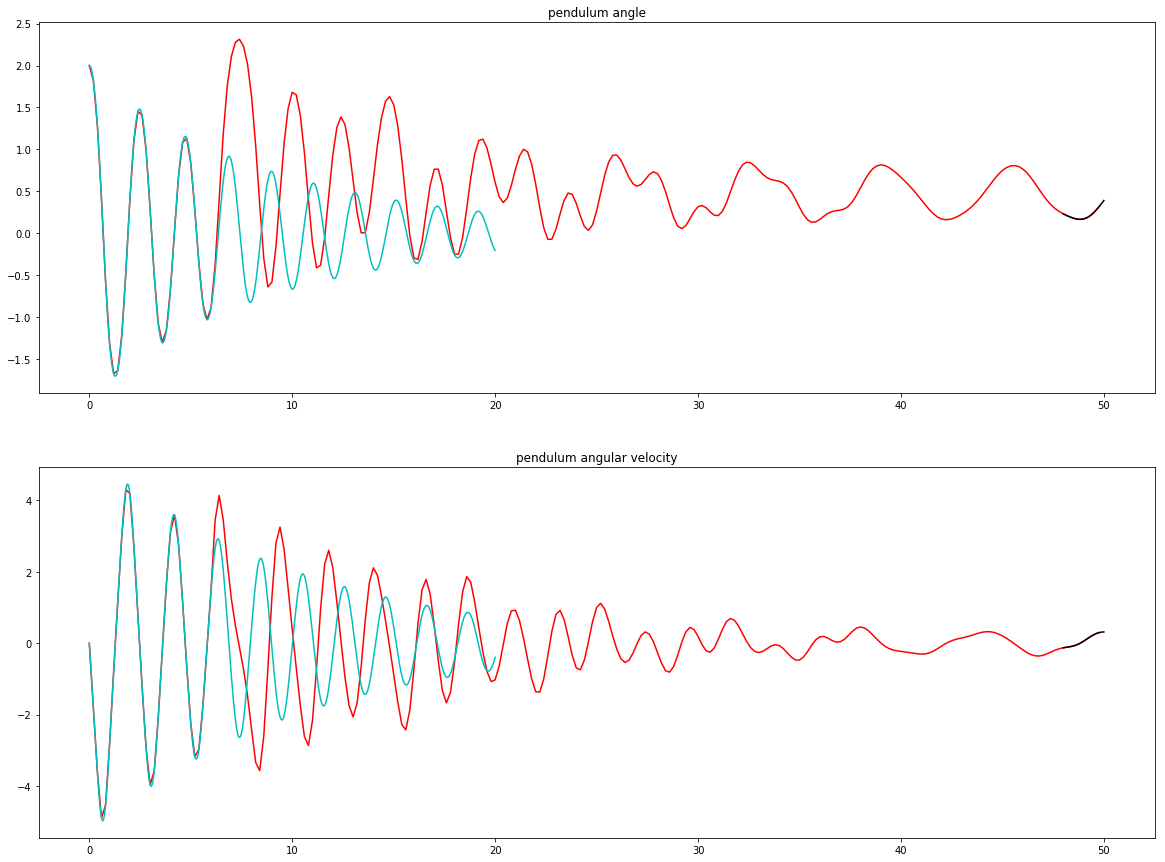

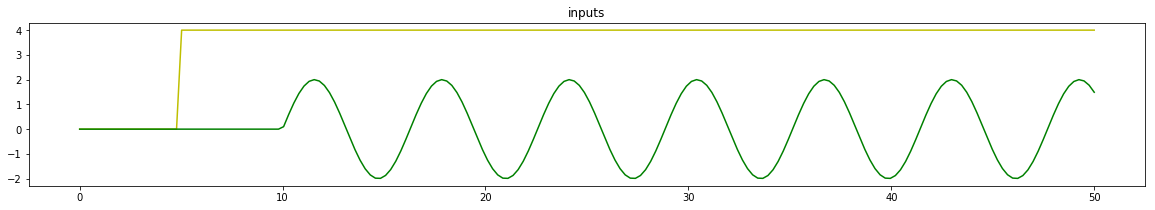

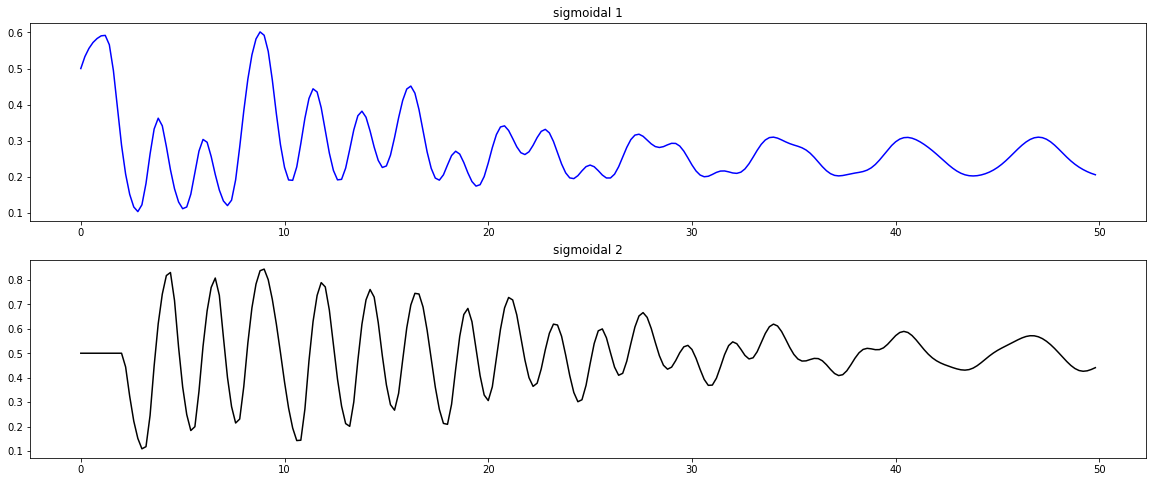

In [3]:
'''
This cell is meant to test the set_plant_output function
'''
# Create parameter dictionaries
plant_params = {'type' : plant_models.pendulum, 'length' : 2., 'inp_gain' : 10., #'delay' : 2.2,
                'mass' : 10., 'mu' : 2., 'init_angle' : 2-(np.pi/2.), 'init_ang_vel' : 0.}
unit_pars = { 'init_val' : 0.5, 'function' : lambda x:None, 'type' : unit_types.source } 
net_params = {'min_delay' : 0.2, 'min_buff_size' : 8, 'rtol' : 1e-5 } # parameter dictionary for the network

# Create network, plant, and input units
n1 = network(net_params)  # creating a newtwork
sources = n1.create(2,unit_pars) # source units
pend = n1.create(1,plant_params) # and a pendulum

# Create some inputs
f1 = lambda x : np.sign(max(0.,x-5.))*4. # 0 for x<5, 4 for x>5
f2 = lambda x : 2.*np.sin(max(0.,x-10.)) # 0 for x<10, 2*sin(x) for x>10
n1.units[sources[0]].set_function(f1)
n1.units[sources[1]].set_function(f2)

# Connect the source units to the pendulum
conn_spec = {'inp_ports' : [0, 0],  # the pendulum only has one input port
             'delays' : [1.0, 2.5]} # connection specification dictionary
syn_pars = {'init_w' : [1.0705, 1.2], 'type' : synapse_types.static} # synapse parameters dictionary
n1.set_plant_inputs(sources, pend, conn_spec, syn_pars)

# Create some units, and send the plant's output to them
unit_pars['type'] = unit_types.sigmoidal
unit_pars['slope'] = 1.
unit_pars['thresh'] = 0.
unit_pars['tau'] = 0.5
unit_pars['n_ports'] = 2
lins = n1.create(2,unit_pars)
conn_spec = {'port_map' : [[(0, 0)],[(1,1)]], # angle to port 0 of unit 1, velocity to port 1 of neuron 2
             'delays' : [1.,2.]} # connection specification dictionary
syn_spec = {'init_w' : [1.]*2, 'type' : synapse_types.static} # synapse parameters dictionary

n1.set_plant_outputs(pend, lins, conn_spec, syn_spec)

# Run the simulation
sim_time = 50.
start_time = time.time()
sim_dat = n1.run(sim_time)
print('Execution time: %s seconds' % (time.time() - start_time))

# In pend.ode the zero angle aligns with the negative Y axis
sim_dat[2][0][:,0] = sim_dat[2][0][:,0] + np.pi/2

xpp_dat = loadData('./tests/pendoderun.dat')

fig = plt.figure(figsize=(20,15))
tims2 = np.linspace(sim_time-2., sim_time, 20)
vals3 =  list(map(lambda x: n1.plants[0].get_state_var(x,0), tims2)) 
vals3 = [x + np.pi/2 for x in vals3]
vals4 =  list(map(lambda x: n1.plants[0].get_state_var(x,1), tims2))
# vals3 and vals4 show angle and velocity as stored in the plant's buffers at the end of the simulation
# They are plotted as the black lines at the right ends, and should agree with the red lines
plt.subplot(211)
plt.plot(sim_dat[0], sim_dat[2][0][:,0], 'r', xpp_dat[0], xpp_dat[1], 'c', tims2,vals3,'k', figure=fig)
plt.title('pendulum angle')

plt.subplot(212); plt.title('pendulum angular velocity')
plt.plot(sim_dat[0], sim_dat[2][0][:,1], 'r', xpp_dat[0], xpp_dat[2], 'c', tims2,vals4,'k', figure=fig)

figi = plt.figure(figsize=(20,3)); plt.title('inputs')
tims = np.linspace(0., sim_time, 200)
vals1 = list(map(n1.units[sources[0]].get_act, tims))
vals2 = list(map(n1.units[sources[1]].get_act, tims))
plt.plot(tims,vals1, 'y', tims,vals2,'g', figure=figi)

figl = plt.figure(figsize=(20,8))
plt.subplot(211); plt.title('sigmoidal 1')
plt.plot(sim_dat[0], sim_dat[1][2], 'b', figure=figl)
plt.subplot(212); plt.title('sigmoidal 2')
plt.plot(sim_dat[0], sim_dat[1][3], 'k', figure=figl)

plt.show()

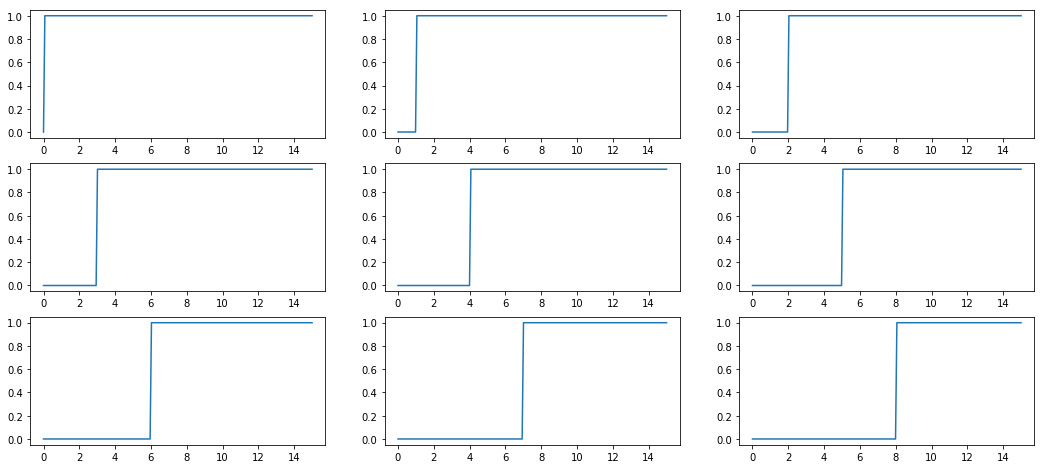

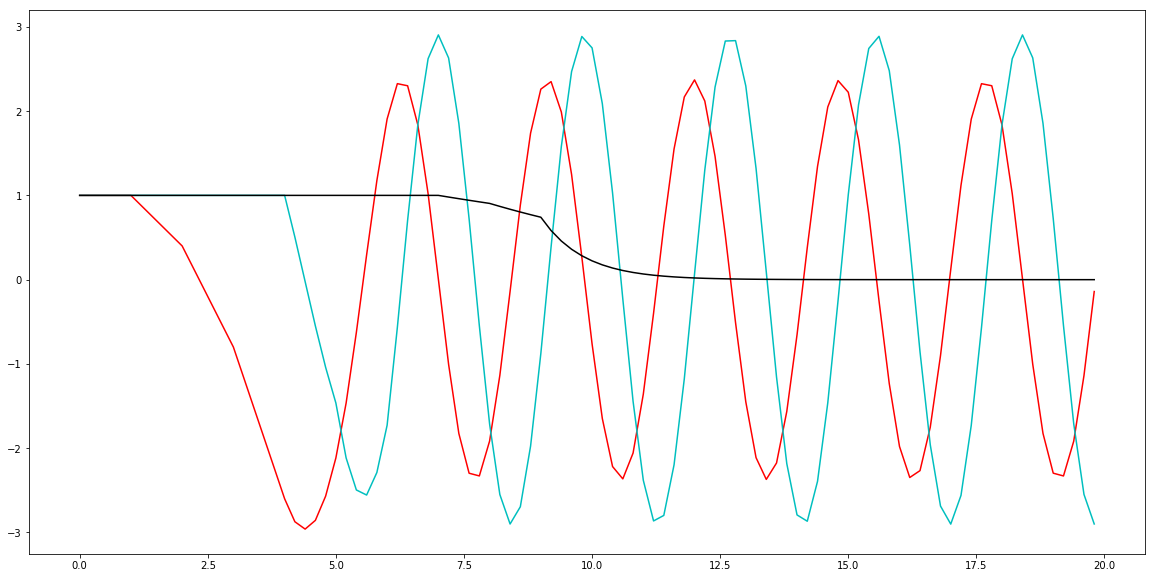

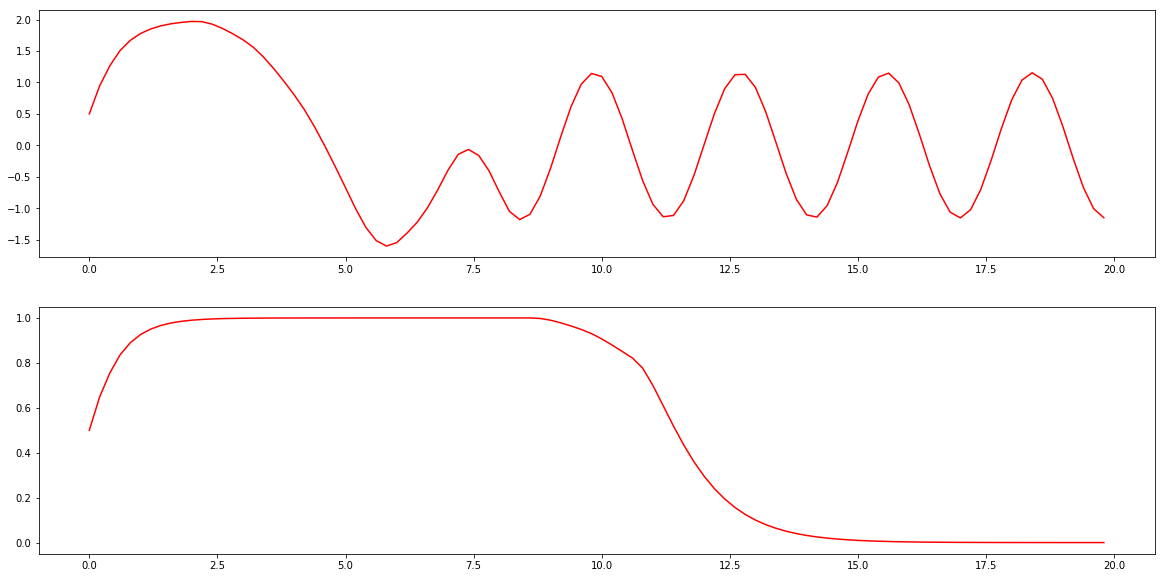

In [4]:
'''
This cell is meant to test the set_plant_input function for multidimensional input
'''
# Create parameter dictionaries
plant_params = {'type' : plant_models.conn_tester, 'init_state' : [1.,1.,1.]}
unit_pars = { 'init_val' : 0.5, 'function' : lambda x:None, 'type' : unit_types.source } 
net_params = {'min_delay' : 0.2, 'min_buff_size' : 4 } # parameter dictionary for the network

# Create network, plant, and input units
n3 = network(net_params)  # creating a newtwork
units = n3.create(9,unit_pars) # source units
plant = n3.create(1,plant_params) # and a test plant

# Create some inputs
def make_Heavi(thr):
    return lambda x : np.sign(max(0.,x - float(thr)))

for idx, unit in enumerate(n3.units):  # Heaviside step functions with increasing thresholds
    unit.set_function(make_Heavi(float(idx)))

# plotting inputs
tims = np.linspace(0.,15.,200)
inp_fig2 = plt.figure(figsize=(18,8))
for idx,unit in enumerate(n3.units):
    vals = list(map(unit.get_act, tims))
    plt.subplot(3,3,unit.ID+1)
    plt.plot(tims,vals)
    
# Connect the source units to the plant
conn_spec = {'inp_ports' : [0, 0, 0, 1, 1, 1, 2, 2, 2], 
             'delays' : [1.]*9} # connection specification dictionary
syn_pars = {'init_w' : [.6,.6,.6,.9,.9,.9,.1,.1,1.], 'type' : synapse_types.static} # synapse parameters dictionary
n3.set_plant_inputs(units, plant, conn_spec, syn_pars)

# Create some units, and send the plant's output to them
unit_pars['type'] = unit_types.mp_linear
unit_pars['slope'] = 1.
unit_pars['thresh'] = 0.
unit_pars['tau'] = 0.5
unit_pars['n_ports'] = 3
lins = n3.create(2,unit_pars)
conn_spec = {'port_map' : [[(0, 0),(1,3)],[(2,2)]], 
             'delays' : [1., 2., 1.6]} # connection specification dictionary
syn_spec = {'init_w' : [1.]*3, 'type' : synapse_types.static} # synapse parameters dictionary

n3.set_plant_outputs(plant, lins, conn_spec, syn_spec)

# Run the simulation
sim_dat = n3.run(20.)

fig = plt.figure(figsize=(20,10))

plt.plot(sim_dat[0], sim_dat[2][0][:,0], 'r', figure=fig)
plt.plot(sim_dat[0], sim_dat[2][0][:,1], 'c', figure=fig)
plt.plot(sim_dat[0], sim_dat[2][0][:,2], 'k', figure=fig)

out_fig = plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(sim_dat[0], sim_dat[1][9], 'r', figure=out_fig)
plt.subplot(212)
plt.plot(sim_dat[0], sim_dat[1][10], 'r', figure=out_fig)

plt.show()